***
# HCI Week 2 - Fourier Transform Optics
*Matthew Kenworthy // Leiden Observatory*
***
Last week you were able to analyse the disk around Beta Pictoris by masking the data using unsharp masking, subtracting off averages of the image and using a reference star. In this tutorial we will go back to some of the mathematics behind these principles. We will: 

* Simulate the Point Spread Function (PSF) of the telescope by using Fourier optics
* Look at the relationship between energy and incoming intensity
* Adding a tilt in the phase across the telescope pupil

Good luck and remember: have fun. 

<div class="alert alert-block alert-info">
<b>Tip:</b> your collegues and Google are your best friends. Please ask each other for help during and after the tutorial (a reminder - helping is not copying!)</div>


Load Python modules into the notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%config InlineBackend.figure_format = 'retina' 

import matplotlib as mpl
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.origin'] = 'lower'


Load in some functions we will use later: `displC`, `padcplx` and `FFT`.

In [2]:
def zoom(im,x,y,bb):
    '''zoom - returns a square 2D image cut out from im centered on location (x,y) and with half-width bb'''
    return(im[y-bb:y+bb,x-bb:x+bb])

def displC(c,trim=0):
    """displC - display a Complex number c as four plots
    
               The top two plots are (Real, Imaginary) quantities
               The bottom two plots are (Amplitude, Phase)
               
               Optionally cut out the central square  with a size of 'trim x trim' pixels"""   
    c2 = np.copy(c)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = c.shape
        dx = int((nx-trim) / 2 + 1)
        dy = int((nx-trim) / 2 + 1)
        c2 = c[dx:dx+trim,dy:dy+trim]
        
    # set up the plot panels
    fig=plt.figure(figsize=(10,8))
    axre = fig.add_subplot(221)
    axim = fig.add_subplot(222)
    axamp = fig.add_subplot(223)
    axpha = fig.add_subplot(224)
    # plot out the panels
    im = axre.imshow(c2.real)
    im = axim.imshow(c2.imag)
    im = axamp.imshow(np.abs(c2))
    im = axpha.imshow(np.angle(c2))
    
    axre.set_title('Real')
    axim.set_title('Imag')
    axamp.set_title('Amplitude')
    axpha.set_title('Phase')
    plt.show()

def padcplx(c,pad=5):
    """padcplx - puts a `Complex` array into the centre of a zero-filled `Complex` array
               pad is an integer defining the padding multiplier for the output array """
    (nx, ny) = c.shape
    bignx = nx*pad + 1
    bigny = ny*pad + 1
    big_c = np.zeros((bignx,bigny),dtype=complex)

    dx = int((nx * (pad-1)) / 2 + 1)
    dy = int((ny * (pad-1)) / 2 + 1)

    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

def FFT(c,pad=5):
    """FFT - carry out a complex Fourier transform (with optional padding)
            c - the input 2D Complex numpy array
            pad - integer multiplier for the padding/sampling
               Returns the `Complex` FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = ifftshift(fft2(fftshift(padcplx(c,pad))))
    return psfA


The functions include documentation defined between two sets of triple quotes (""") so let us see what these functions are doing:

In [3]:
print(displC.__doc__)
print(padcplx.__doc__)
print(FFT.__doc__)

displC - display a Complex number c as four plots
    
               The top two plots are (Real, Imaginary) quantities
               The bottom two plots are (Amplitude, Phase)
               
               Optionally cut out the central square  with a size of 'trim x trim' pixels
padcplx - puts a `Complex` array into the centre of a zero-filled `Complex` array
               pad is an integer defining the padding multiplier for the output array 
FFT - carry out a complex Fourier transform (with optional padding)
            c - the input 2D Complex numpy array
            pad - integer multiplier for the padding/sampling
               Returns the `Complex` FFT padded array


## Useful numpy commands 

One extremely useful command is the `mgrid` command. It produces two separate numpy arrays in a list, the first array with X values and a second array with Y values. These can be used as X and Y coordinates in evaluating a function across an image. Read the `numpy` documentation for details, or use the online help. `imshow` and `plot` display data in a plot shown below the cell.


<div class="alert alert-block alert-success">
<b>Example 2.1:</b> lets create an image! Our image will be a simple meshgrid, made using <code>np.mgrid</code> containing the range $0-11$. We can show our image by plotting the x and y grid obtained with <code>np.mgrid</code>.
</div>

[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 0  1  2  3  4  5  6  7  8  9 10 11]]


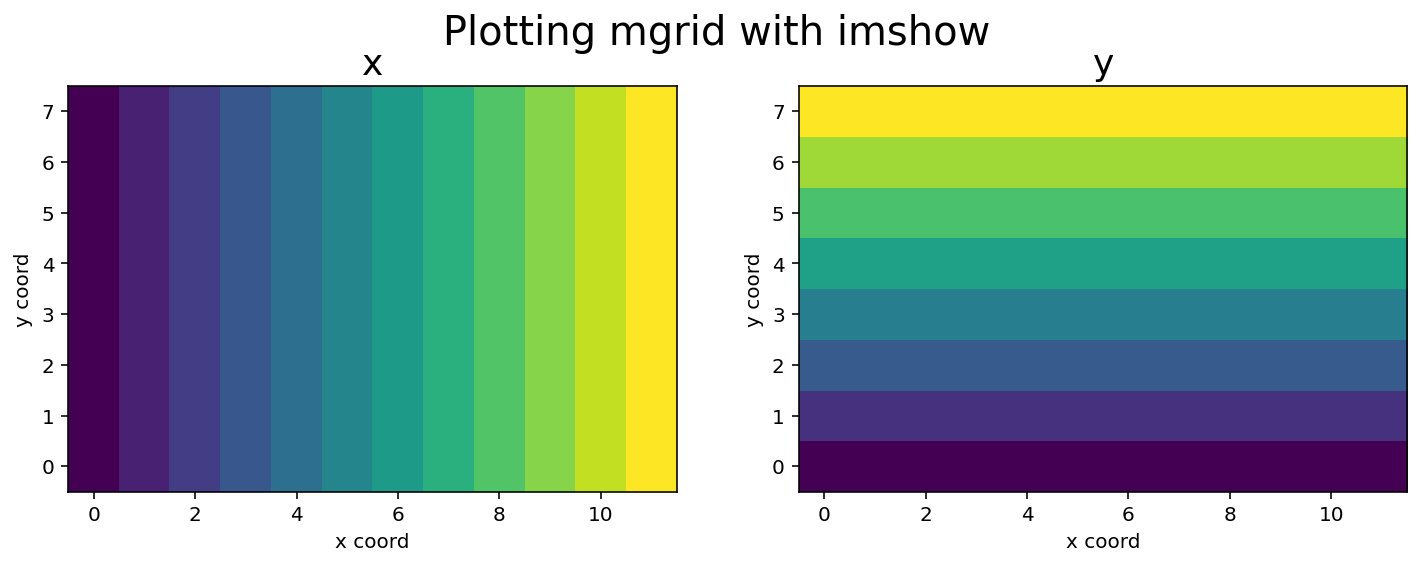

In [4]:
y,x = np.mgrid[0:8,0:12]
print(x)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))    

ax1.set_xlabel('x coord');  ax1.set_ylabel('y coord')                    
ax2.set_xlabel('x coord');  ax2.set_ylabel('y coord')                    

fig.suptitle('Plotting mgrid with imshow', fontsize=20)
ax1.set_title('x', fontsize=18);  ax2.set_title('y', fontsize=18)                    

image = ax1.imshow(x)    ;   image2 = ax2.imshow(y)

plt.show()

**IMPORTANT!** Most scientists expect the origin of any plot to be in the lower left corner. With `numpy` and `matplotlib` the default position is in the UPPER LEFT corner.

At the top of this Notebook, we told `matplotlib` to put the origin in the LOWER LEFT corner with the command `mpl.rcParams['image.origin'] = 'lower'`.

**PRINTING A NUMPY ARRAY WILL STILL HAVE THE ORIGIN IN THE UPPER LEFT CORNER!! WATCH OUT FOR THIS!!**


## Making Masks and Shapes


What can you do with these arrays? You can evaluate functions in one simple step with no `for` loops like more traditional computer languages. These functions can then act as shapes with which to define masks for use in making telescope pupils, later on in the workbook.


<div class="alert alert-block alert-success">
<b>Example 2.2:</b> You can calculate the value of the function $x+2y$ for all pixels in an image:
</div>

[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [ 2  3  4  5  6  7  8  9 10 11 12 13]
 [ 4  5  6  7  8  9 10 11 12 13 14 15]
 [ 6  7  8  9 10 11 12 13 14 15 16 17]
 [ 8  9 10 11 12 13 14 15 16 17 18 19]
 [10 11 12 13 14 15 16 17 18 19 20 21]
 [12 13 14 15 16 17 18 19 20 21 22 23]
 [14 15 16 17 18 19 20 21 22 23 24 25]]


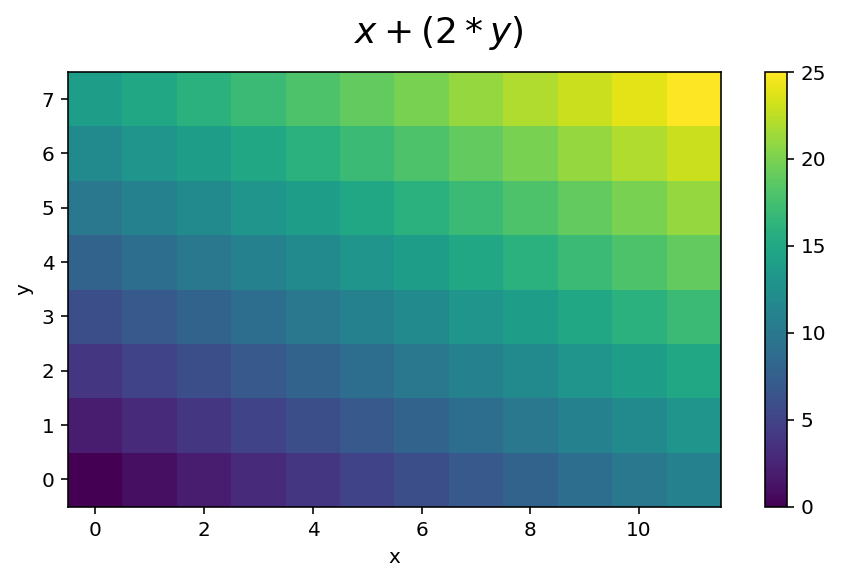

In [5]:
equation = x+2*y
print (equation)

fig, ax = plt.subplots(1, figsize=(8,4))    

ax.set_xlabel("x")                    
ax.set_ylabel("y")                    
fig.suptitle("$x + (2*y)$", fontsize=18) 

image = ax.imshow(equation)
plt.colorbar(image, ax=ax)

plt.show()

**NOTE HOW THE `print(equation)` has small values in the uppper left corner, but the `ax.imshow()` has it in the LOWER LEFT corner!**


<div class="alert alert-block alert-success">
<b>Example 2.2 (continued):</b> We can now make a mask showing where all the points satisfy the equation $x+2y<8$
</div>



[[ True  True  True  True  True  True  True  True False False False False]
 [ True  True  True  True  True  True False False False False False False]
 [ True  True  True  True False False False False False False False False]
 [ True  True False False False False False False False False False False]
 [False False False False False False False False False False False False]
 [False False False False False False False False False False False False]
 [False False False False False False False False False False False False]
 [False False False False False False False False False False False False]]


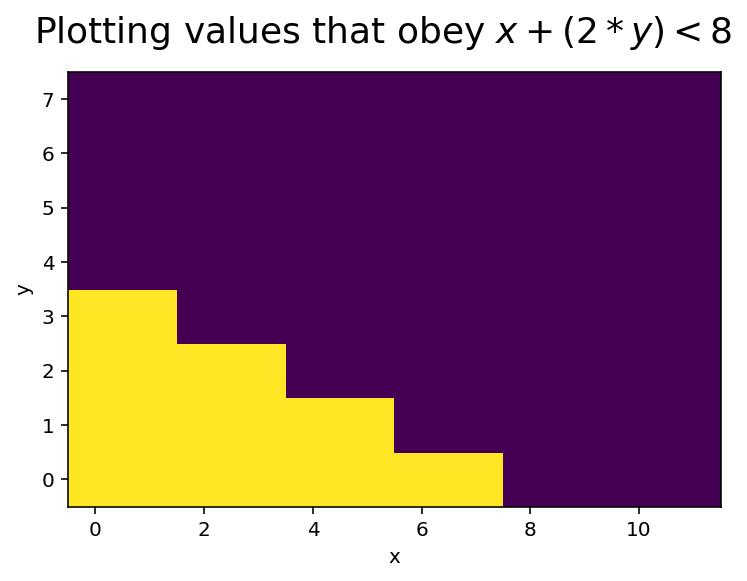

In [6]:
inequality = (x + (2*y) < 8)
print(inequality)

fig, ax = plt.subplots(1, figsize=(6,4))    

ax.set_xlabel("x")                    
ax.set_ylabel("y")                    
fig.suptitle("Plotting values that obey $x + (2*y) < 8$", fontsize=18) 

image = ax.imshow(inequality)
plt.show()

The `inequality` contains `True` and `False` values which appear as white and dark squares in `imshow`.

---
<span style="  font-size:2em; color: SteelBlue;">Question 2.1</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

The formula for a circle having its centre located at an arbitrary position $(x_c,y_c)$ and radius $r$ is given by the equation:

$$(x-x_c)^2 + (y-y_c)^2 < r^2$$ 

The points within a circle centered at the origin $(0,0)$ with a radius of 6 is therefore: $x^2 + y^2 < 6^2.$

**Display the equation $x^2 + y^2 < 6^2.$ for $x$ and $y$ defined in the cells above.** 

Hint: You can do this with one line of code following the example in the 'Making Masks and Shapes' section.

---

[[ True  True  True  True  True  True False False False False False False]
 [ True  True  True  True  True  True False False False False False False]
 [ True  True  True  True  True  True False False False False False False]
 [ True  True  True  True  True  True False False False False False False]
 [ True  True  True  True  True False False False False False False False]
 [ True  True  True  True False False False False False False False False]
 [False False False False False False False False False False False False]
 [False False False False False False False False False False False False]]


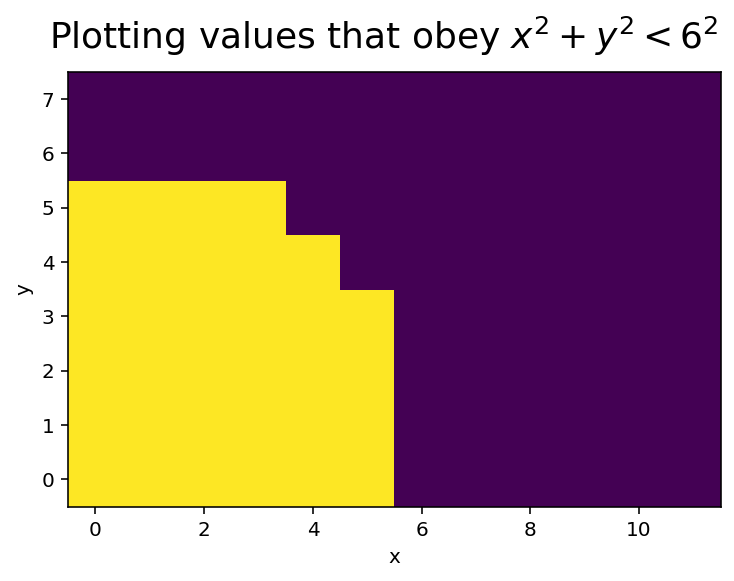

In [7]:
# Q1 answer here
eqn = x**2+y**2<6**2
print(eqn)

fig, ax = plt.subplots(1, figsize=(6,4))    

ax.set_xlabel("x")                    
ax.set_ylabel("y")                    
fig.suptitle("Plotting values that obey $x^2 + y^2 < 6^2$", fontsize=18) 

image = ax.imshow(eqn)
plt.show()

---
<span style="  font-size:2em; color: SteelBlue;">Question 2.2</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>



**Write your own function `circle_mask` that takes a 2D array `im`, circle center coordinates $x_c, y_c$ and a radius $r$ as input parameters.**

It should return a mask array with the same shape as the input 2D array `im` that evaluates the equation $(x-x_c)^2 + (y-y_c)^2 < r^2$. Show that your function works by putting a circle of radius 5.2 with centred at (7.6, 10.3) in an array of 35 by 25 pixels. Plot the results with `imshow`.

---

**NOTE:** the output image should **NOT** overwrite the input image! You almost never want to overwrite your input image.

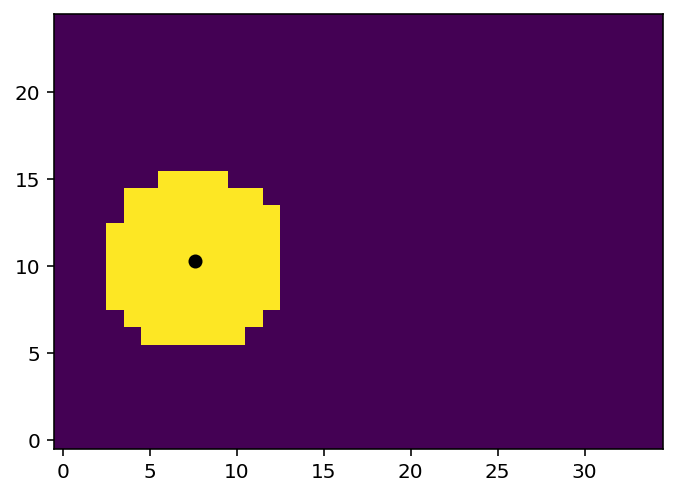

In [8]:
# Q2 answer here


def circle_mask(im, xc, yc, rcirc):
    """circle_mask - This is your own function"""
    m,n = im.shape
    y,x = np.mgrid[0:m,0:n]
    eqn = (x-xc)**2+(y-yc)**2<rcirc**2
    return eqn
    # ....
    #return (....)

img = np.zeros((25,35))
out = circle_mask(img,7.6,10.3,5.2)
plt.plot(7.6,10.3,'o',color='k')
plt.imshow(out)
plt.show()

---
<span style="  font-size:2em; color: SteelBlue;">Question 2.3</span> <span style="  font-size:1em; color: SteelBlue;">
(5 points): </span>

**Use your `circle_mask()` routine to cut out the central 11 pixels in the Beta Pictoris coronagraphic image from last week's practicum**

<div class="alert alert-block alert-info">
<b>Steps:</b> 
<ol> <li> Read in the Beta Pictoris image and cut out an image 50x50 pixels centered on the star's image</li>
    <li> Use your routine to make a mask with a circle 11 pixels in diameter and the Beta Pictoris as an input</li>
    <li> Show your result by displaying the image with the applied circle mask by using <code>imshow()</code>.</li>
</ol>
</div>

<div class="alert alert-block alert-info">
<b>Hint:</b> Look at your answer of Question 1.3 of the last tutorial. You can make use of the <code>zoom()</code> function. </div>

---

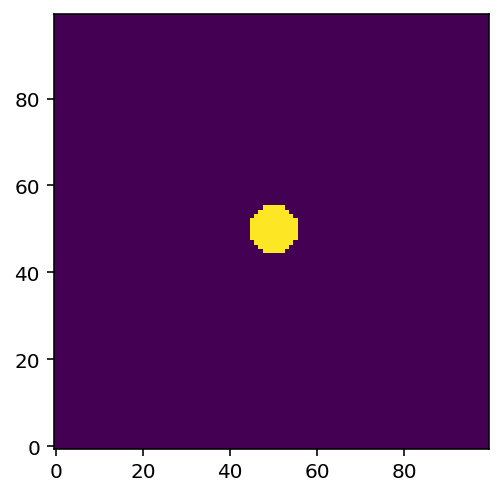

In [9]:
from astropy.io import fits
from astropy.convolution import convolve

# Q3 answer here

# loading in the images into the Notebook.
pic1, pic1_header = fits.getdata("../week_1/beta_pic_kalas_1995/pic1.fits", header=True)
xcen = 262 - 1;   ycen = 198 - 1

# creating a mask to cut the central 11 pixels

Mask = circle_mask(pic1, xcen, ycen, 11/2)

# plot the masked result

plt.imshow(zoom(Mask, xcen, ycen, 50))
plt.show()

## Simulating PSFs with Fourier Optics


A simple imaging lens forms an image of the sky on a detector.

The lens converts incoming wavefronts of light into angular positions that are recorded on a detector.

In the Fraunhofer limit, the wavefront incident on the lens described by the electric field $\mathbf{E}$. This can be represented by a complex number

$$\mathbf{E} = E\cdot e^{(i\phi)},$$ 

where $E$ and $\phi$is are real numbers and $\mathbf{E}$ is a complex number containing both the electric field amplitude and phase.

The resultant electric field at the detector is given by the Fourier transform of $E_{det}=\mathcal{F}(\mathbf{E})$, where $\mathcal{F}$ is the Fourier transform operator.

<div class="alert alert-block alert-info">
<b>Tip:</b> The `numpy` module can work with complex numbers of the form $a \pm bi$. 
We can use it to build a complex array by using the letter `j` to represent the imaginary constant.For example lets take (a,b) = (4,8)
    
    In [1]: c1 = 4+8j
    In [2]: c2 = complex(4,8)
    In [3]: c1 == c2
    
    Out[3]: True
    
</div>

Let us see if we can visualise a Fourier transformation.

<div class="alert alert-block alert-success">
<b>Example 2.3:</b> We make a square aperture of 21 by 21 pixels with zero phase ($\phi=0$) across the entire aperture and an isotropic electric field amplitude ($E=1$). Thereafter, we carry out a Fourier transormation on the square aperture to obtain $E_{det}$</div>

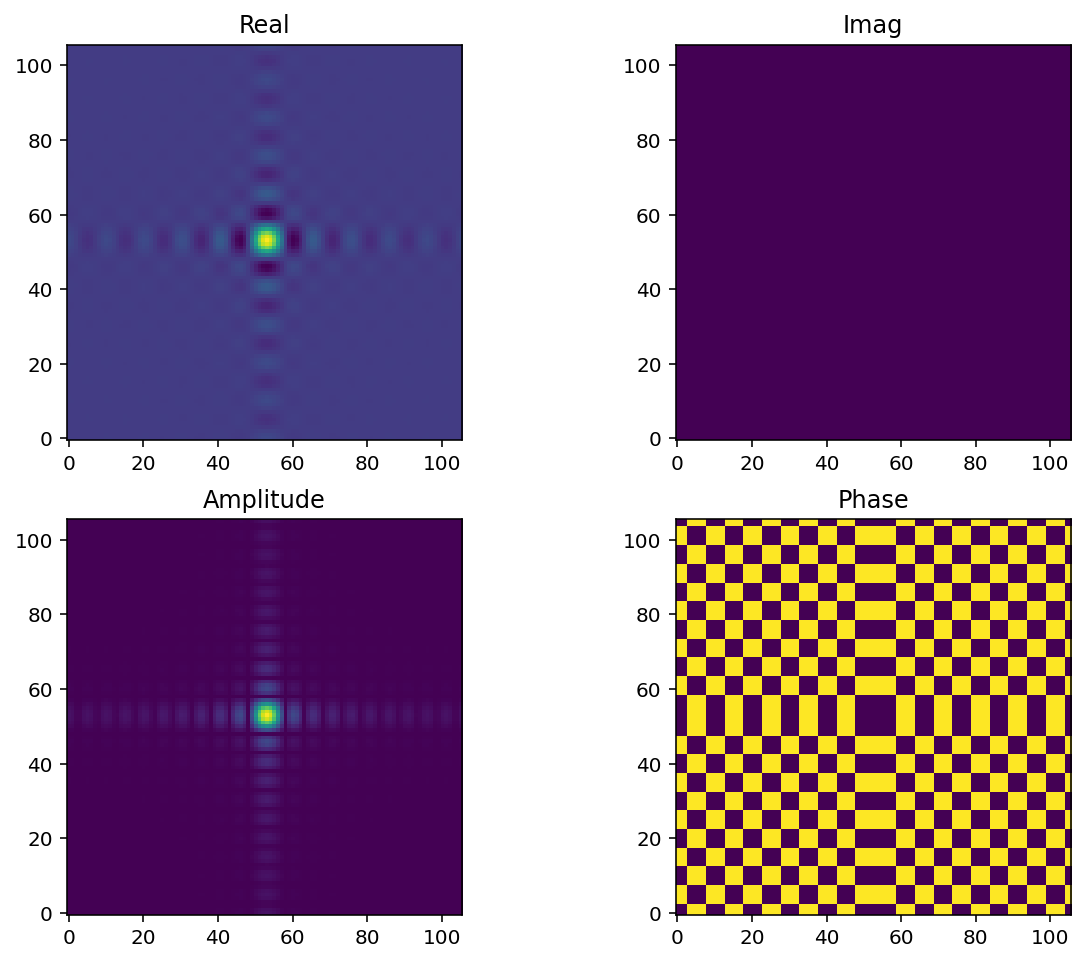

In [10]:
npix = 21

y,x = np.mgrid[:npix, :npix]

ampli = np.ones_like(y)
phase = np.zeros_like(y)  # zero phase across entire aperture

# make the complex amplitude E
E = ampli * np.exp(1j*phase)

# carry out the FT of E and add a spatial sampling of 5 by default
# recall: the functions FFT and displC where the functions defined in the beginning of this notebook
Edet = FFT(E,5)

# display the central part of Edet
displC(Edet)

The function `displC` plots out the complex image $E_{det}$ in two formats 
1. the Real ($a$) and Imaginary ($b$) components, and as 
2. the complex exponential notation with an Amplitude ($A$) and Phase ($\phi$).

### Intensity 

You can also calculate the **intensity** as seen on a detector $I_{det}$ by calculating the modulus squared of the electric field on the detector:


$$I_{det} = \|E_{det}\|^2 = E_{det} \cdot \text{conj}(E_{det}) = \texttt{np.abs(E)} * \texttt{np.abs(E)}$$

<div class="alert alert-block alert-success">
<b>Example  2.4:</b> We want to determine the normalised intensity image from our resultant electric field at the detector, $E_{det}$, as calculated in the previous example. 
    
First we have to take the absolute value squared of $E_{det}$, then normalise by the highest value in $I_{det}$ to determine the normalised intensity image.</div>

Text(0.5, 0.98, '$I_{det}$ as function of pixel position')

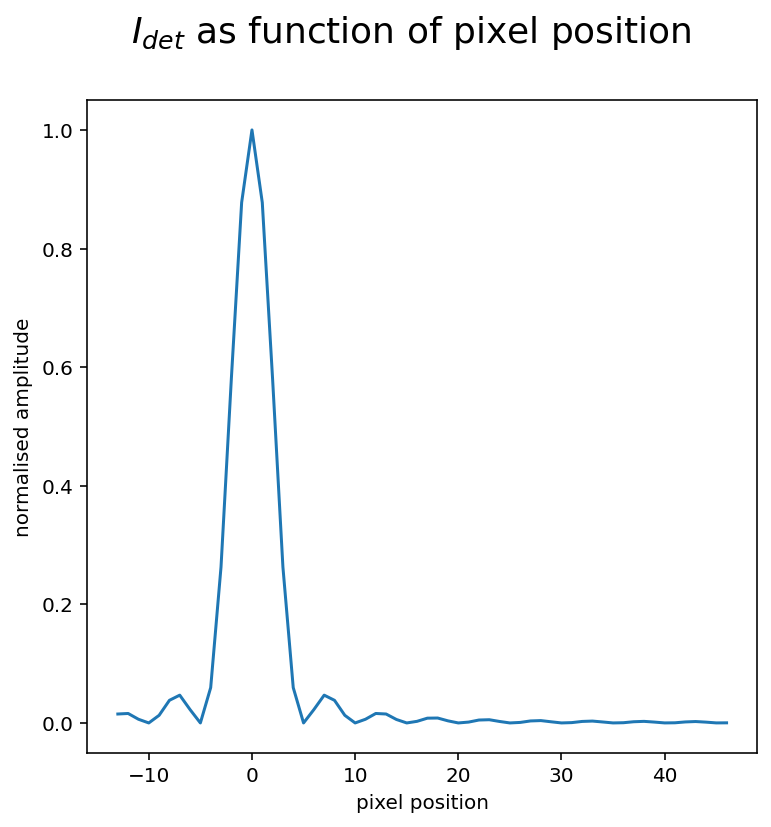

In [11]:
Edet_ampl = np.abs(Edet)

# determine intensity
Idet = Edet_ampl * Edet_ampl

# normalise to the brightest pixel
Idet = Idet / np.max(Idet)

# get central row in Edet and Idet
nx, ny = Edet_ampl.shape

yy, xx = np.mgrid[:nx,:ny]

xc = int((nx + 1)/2.)
yc = int((ny + 1)/2.)

# central pixel is at yy,xx = (0,0)
yy = yy - yc
xx = xx - xc

fig, ax = plt.subplots(1, figsize=(6,6))  

ax.plot(xx[xc,40:100],Idet[xc,40:100])

ax.set_xlabel('pixel position')                 
ax.set_ylabel('normalised amplitude')               
fig.suptitle('$I_{det}$ as function of pixel position', fontsize=18) 

---
<span style="  font-size:2em; color: SteelBlue;">Question 2.4</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Estimate the height of the first sidelobe in the normalised intensity image by adjusting the y scale of the plot using `axes.Axes.set_ylim()`. Label your x and y axes on the plot using `axes.Axes.set_xlabel()` and `axes.Axes.set_ylabel()`**

---

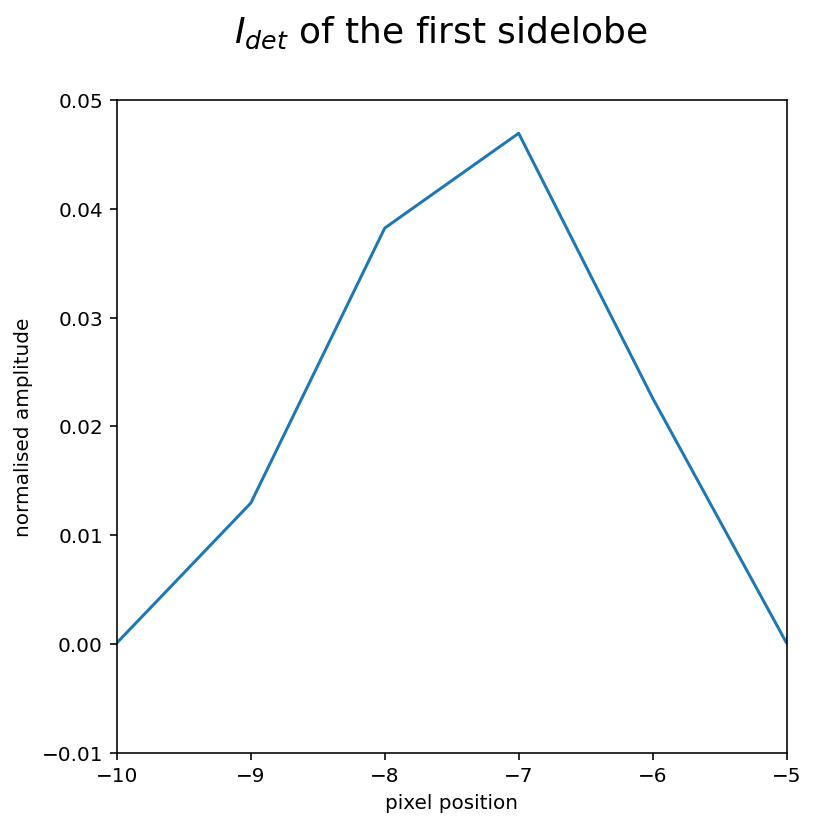

The height of the first sidelobe is estimated to be:  4.70e-02


In [12]:
# Q4 answer here
fig, ax = plt.subplots(1, figsize=(6,6))  

ax.plot(xx[xc,40:100],Idet[xc,40:100])

ax.set_xlabel('pixel position')                 
ax.set_ylabel('normalised amplitude')   
ax.set_xlim([-10,-5])
ax.set_ylim([-.01,.05])
fig.suptitle('$I_{det}$ of the first sidelobe', fontsize=18) 
plt.show()

# estimating height of side lobe
xval = xx[xc,40:100]
yval = Idet[xc,40:100]
I_side_msk = (xval<-5)*(xval>-10)*(yval<.05)*(yval>-.01)
I_side = np.max(yval[I_side_msk])
print("The height of the first sidelobe is estimated to be: ",'%.2e'%I_side)

---
<span style="  font-size:2em; color: SteelBlue;">Question 2.5</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>


**Plot the same quantity as for question 1.3 but on a logarithm 10 scale. Where are the first five minima located relative to the central peak (measured in pixels and estimated by visual inspection) from the central peak?**

---

<div class="alert alert-block alert-info">
<b>Tip:</b> "Google is your best friend, (do a Google search for the numpy function to get a logarithm)"
    
</div>

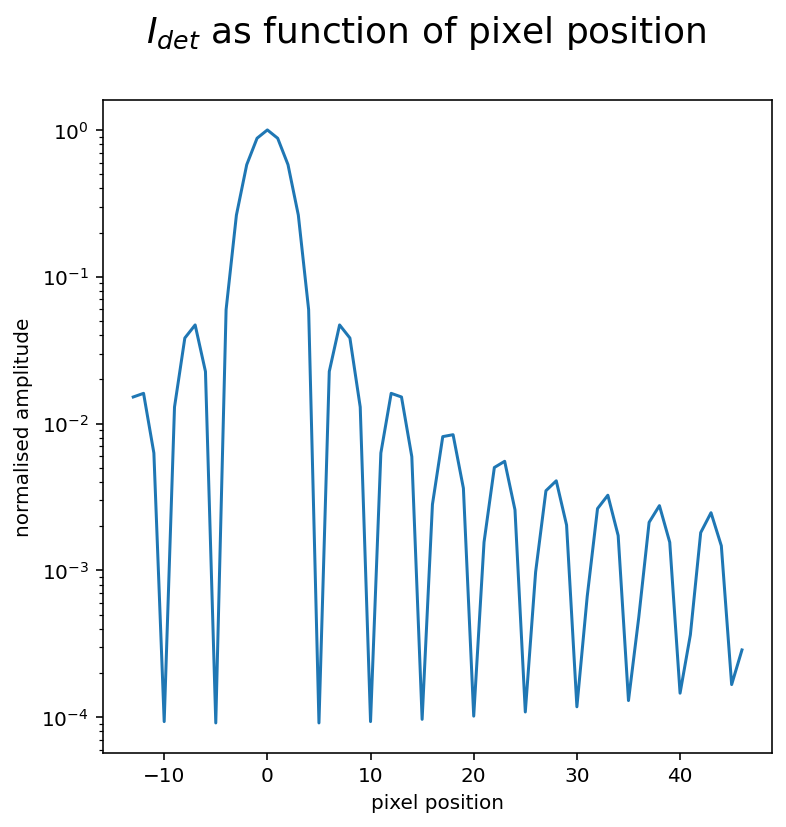

The first 5 minima are located at: 5,10,15,20,25.


In [13]:
fig, ax = plt.subplots(1, figsize=(6,6))  

ax.semilogy(xx[xc,40:100],Idet[xc,40:100])
ax.set_xlabel('pixel position')                 
ax.set_ylabel('normalised amplitude')               
fig.suptitle('$I_{det}$ as function of pixel position', fontsize=18) 
plt.show()
print("The first 5 minima are located at: 5,10,15,20,25.")

---
<span style="  font-size:2em; color: SteelBlue;">Question 2.6</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>


**Change the sampling factor (currently 5) in the `FFT(E,5)` function to different integers. What happens to the pixel locations of the minima?**

---

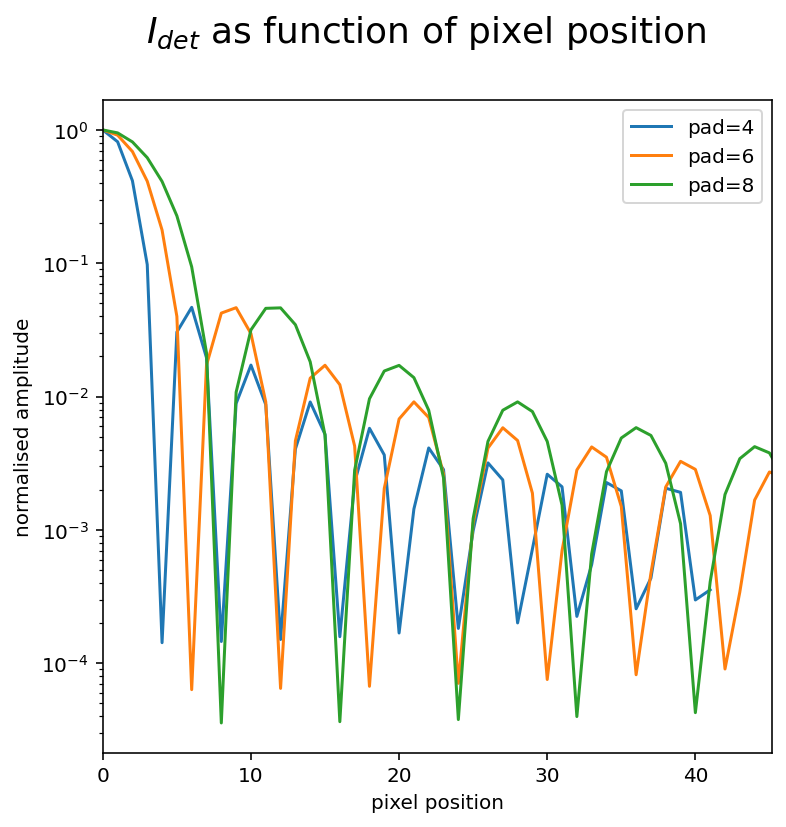

In [14]:
# Q6 answer here
fig, ax = plt.subplots(1, figsize=(6,6))  
for pad in [4,6,8]:
    Edet = FFT(E,pad)
    Edet_ampl = np.abs(Edet)

    # determine intensity
    Idet = Edet_ampl * Edet_ampl

    # normalise to the brightest pixel
    Idet = Idet / np.max(Idet)

    # get central row in Edet and Idet
    nx, ny = Edet_ampl.shape

    yy, xx = np.mgrid[:nx,:ny]

    xc = int((nx + 1)/2.)
    yc = int((ny + 1)/2.)

    # central pixel is at yy,xx = (0,0)
    yy = yy - yc
    xx = xx - xc
    
    

    ax.semilogy(xx[xc],Idet[xc],label='pad={}'.format(pad))
    ax.set_xlim([0,None])
    ax.set_xlabel('pixel position')                 
    ax.set_ylabel('normalised amplitude')               
    fig.suptitle('$I_{det}$ as function of pixel position', fontsize=18) 
ax.legend()
plt.show()


It can be seen from the plot above, the pixel locations of the first 5 sidelobes become further relative to the central peak with  increasing padding number.

---
<span style="  font-size:2em; color: SteelBlue;">Question 2.7</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>


**In the example we created a squared telescope pupil of 21 by 21 pixels. Now it is your turn to try a new telescope pupil - make a circular pupil with a diameter of 101 pixels, and calculate the PSF (equivalent to calculating $I_{det}$) and display it with `displC()`**

---

************************* Display Edet *************************


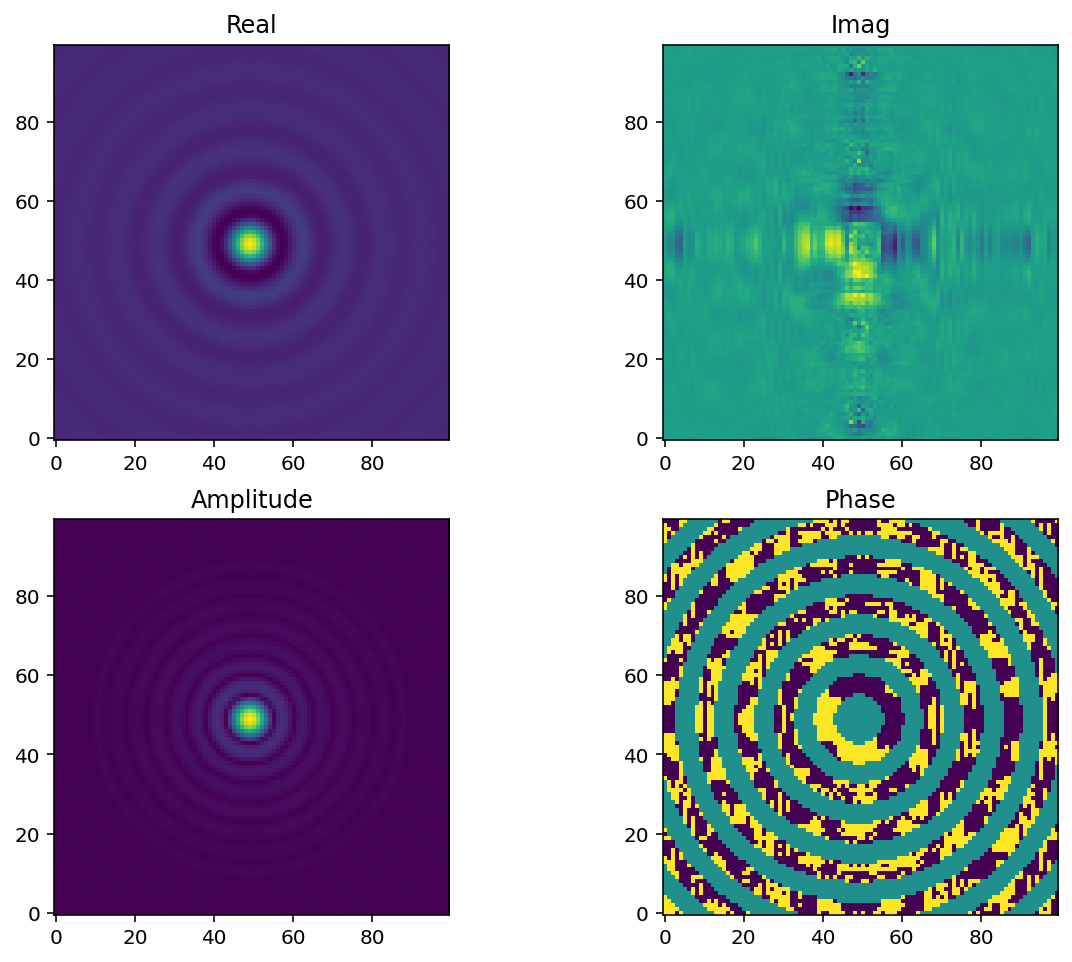

************************* Display Idet *************************


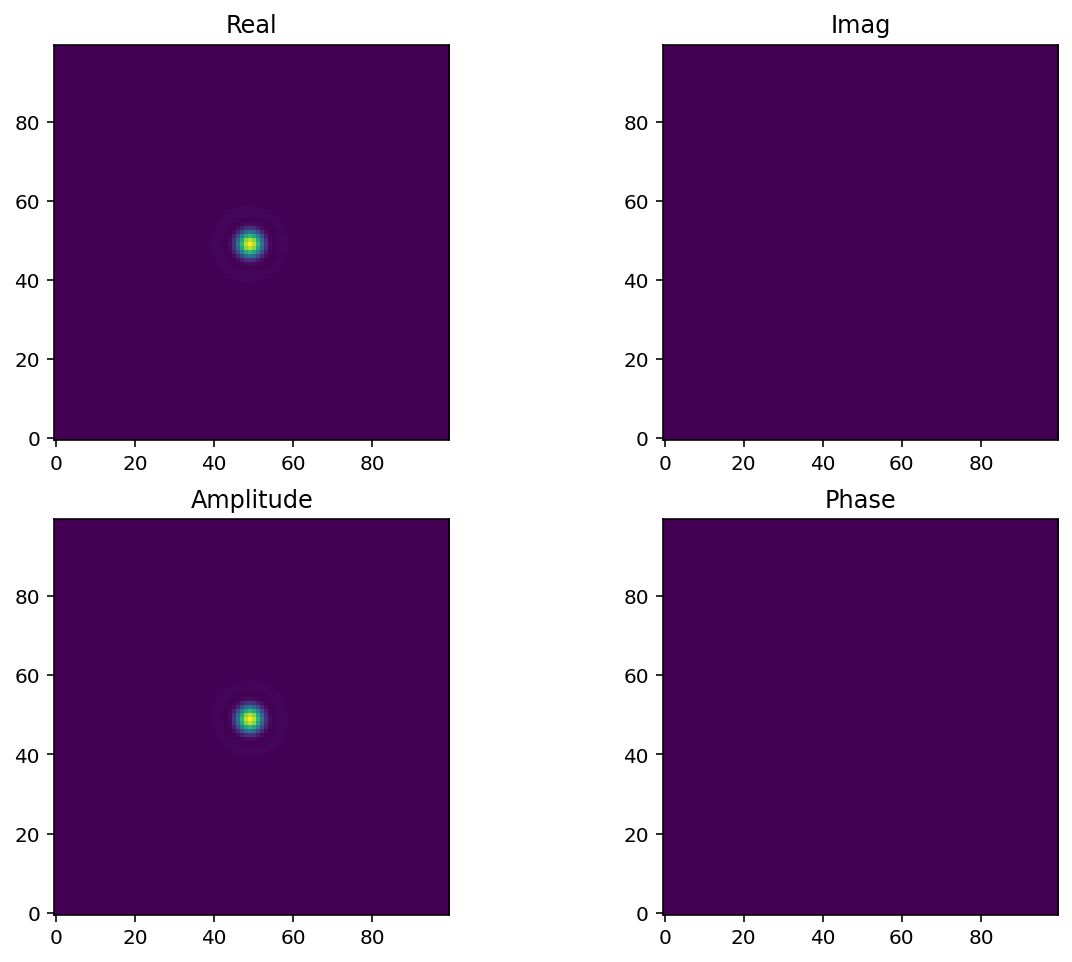

In [15]:
# make a circular pupil with a diameter of 101 pixels
dim = 101
# make x,y coords for making telescope pupil
y,x = np.mgrid[:dim, :dim]
ampli = np.ones_like(y)
phase = np.zeros_like(y)  # zero phase across entire aperture
E = ampli * np.exp(1j*phase)
# generate radial values mask r centered in middle of image
out = circle_mask(E,50,50,50.5)
# values outside the circle are defined as zeros
E[out==0] = 0
Edet = FFT(E,5)
print("*"*25,"Display Edet","*"*25)
displC(Edet,100)
# get amplitude of Edet
Edet_ampl = np.abs(Edet)

# determine intensity
Idet = Edet_ampl * Edet_ampl
# make and display the intensity image ( = A * conj(A) )
print("*"*25,"Display Idet","*"*25)
displC(Idet,100)


---
<span style="  font-size:2em; color: SteelBlue;">Question 2.8</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>


**Normalise the PSF of question 2.7 and use `displC` to display the log10 of the PSF. Plot the central row of pixels showing the peak of the PSF twice: once using linear and once using log10 units.**

---

Text(0.5, 0.98, '$I_{det}$ as function of pixel position')

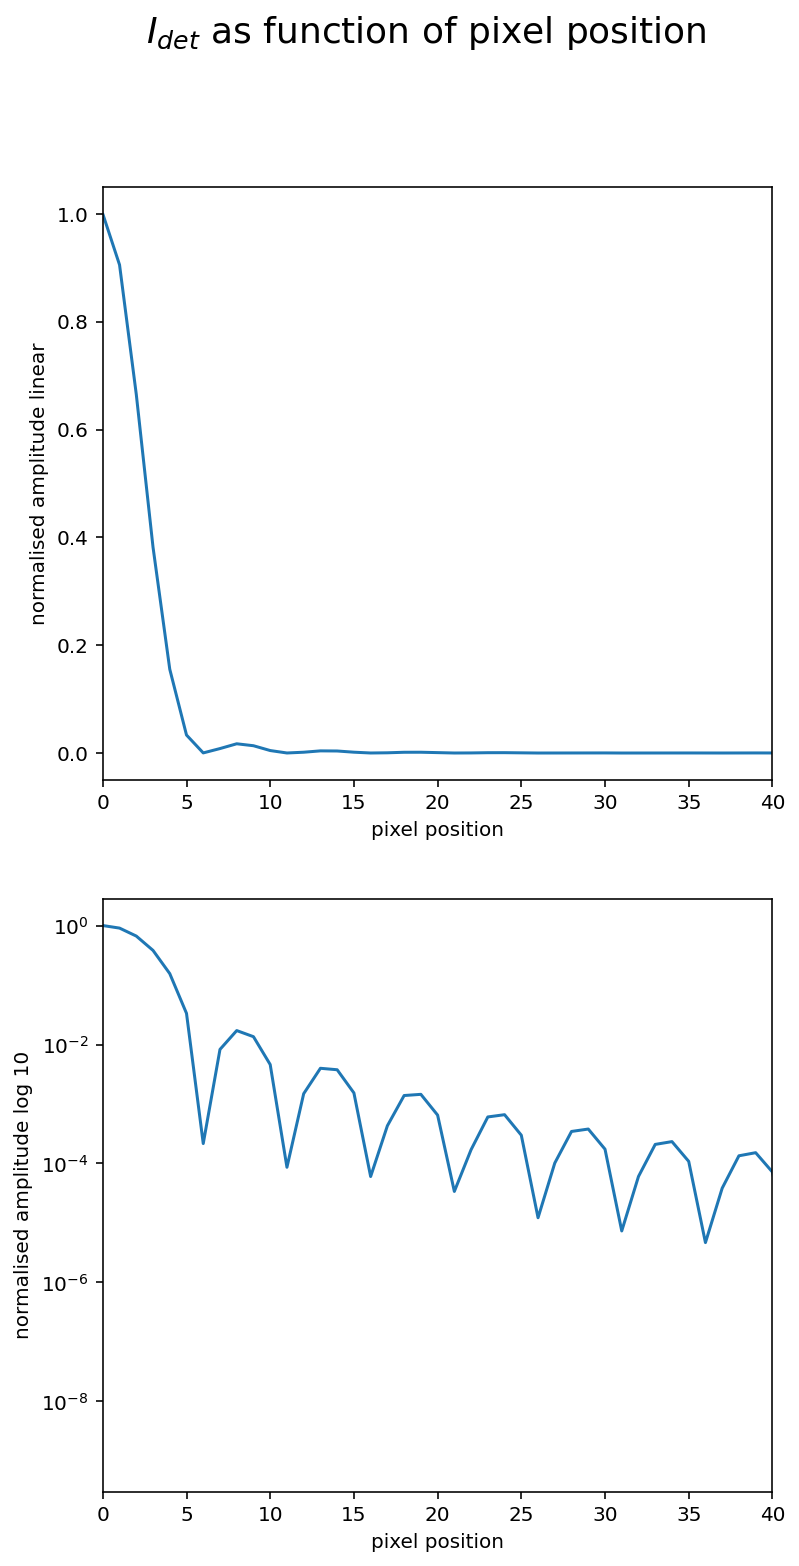

In [16]:
# Q8 answer here

# normalise to the peak value
Idet = Idet / np.max(Idet)
# plot out the central line
# get central row in Edet and Idet
nx, ny = Edet_ampl.shape

yy, xx = np.mgrid[:nx,:ny]

xc = int((nx + 1)/2.)
yc = int((ny + 1)/2.)

# central pixel is at yy,xx = (0,0)
yy = yy - yc
xx = xx - xc

fig, [ax1,ax2] = plt.subplots(2, figsize=(6,12))  

ax1.plot(xx[xc],Idet[xc])
ax1.set_xlim(0,40)
ax1.set_xlabel('pixel position')                 
ax1.set_ylabel('normalised amplitude linear')  

ax2.semilogy(xx[xc],Idet[xc])
ax2.set_xlim(0,40)
ax2.set_xlabel('pixel position')                 
ax2.set_ylabel('normalised amplitude log 10')  
fig.suptitle('$I_{det}$ as function of pixel position', fontsize=18) 

---
<span style="  font-size:2em; color: SteelBlue;">Question 2.9</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

**Where is (approximately) the first minimum measured from the primary peak of the PSF? Give your answer in units of pixels**

---

(0.0, 15.0)

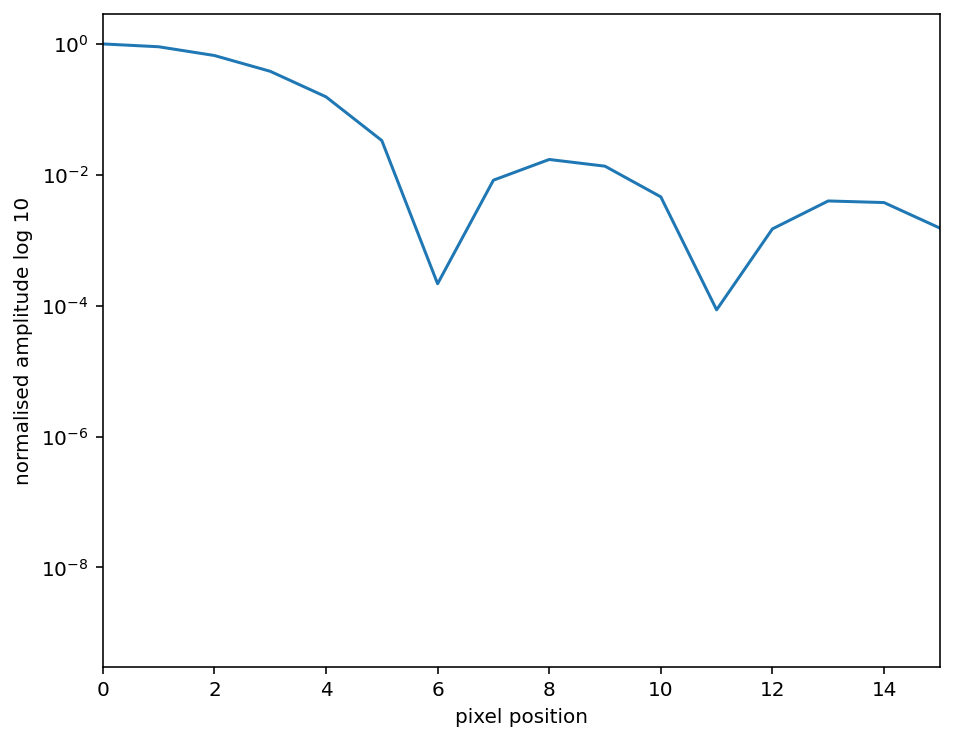

In [17]:
plt.figure(figsize=(7.5,6))
plt.semilogy(xx[xc],Idet[xc])
plt.xlabel('pixel position')                 
plt.ylabel('normalised amplitude log 10')  
plt.xlim([0,15])

The first minimum is at pixel position $\sim$ 6.

## Adding a tilt in the phase across the telescope pupil

The final exercise is modelling a tilted wavefront that is incident on the lens. We do this by adding a 'ramp' in the x-direction. This ramp goes from $-3\pi$ to $+3\pi$ across the telescope pupil. 

You can use `mgrid` to get an x and y grid of points which will also be unnormalised ramps in both x and y. To center the ramp you subtract the middle x value of each x value to obtain a value of 0 in the middle of the x array. Thereafter you normalise the ramp to obtain the correct amplitude.

---
<span style="  font-size:2em; color: SteelBlue;">Question 1.10</span> <span style="  font-size:1em; color: SteelBlue;">
(4 points): </span>


**Display the PSF. What has happened to the position of the PSF? By how far has it moved? Experiment with different multiples of $\pi$ for the ramp.**

---

******************** 3 pi ********************


<Figure size 432x288 with 0 Axes>

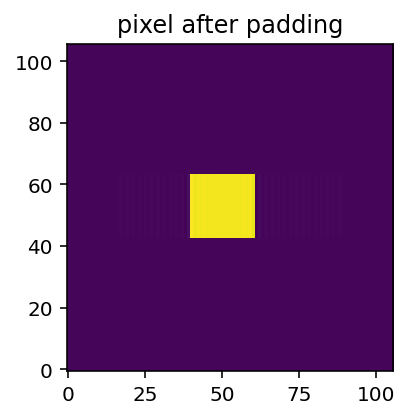

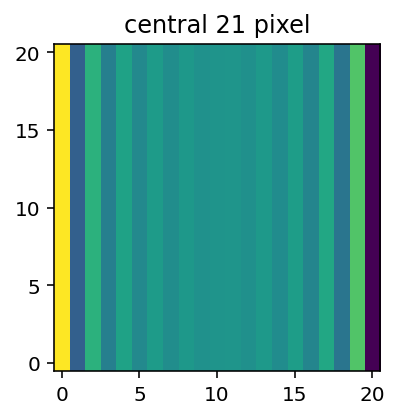

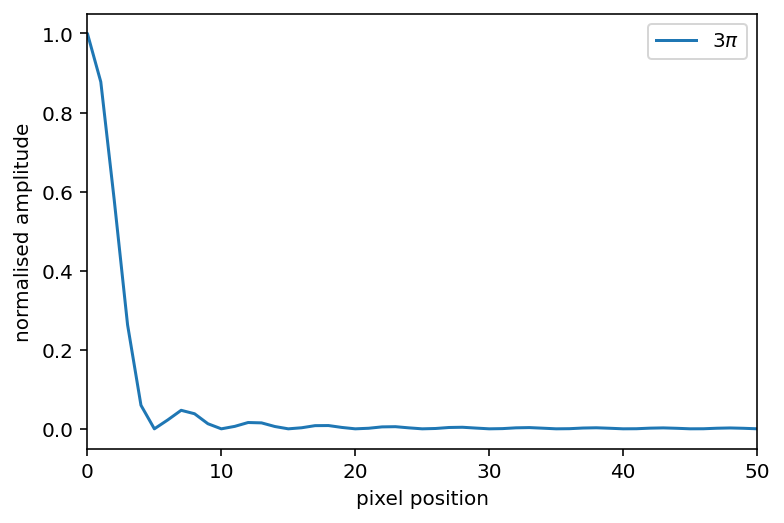

******************** 15 pi ********************


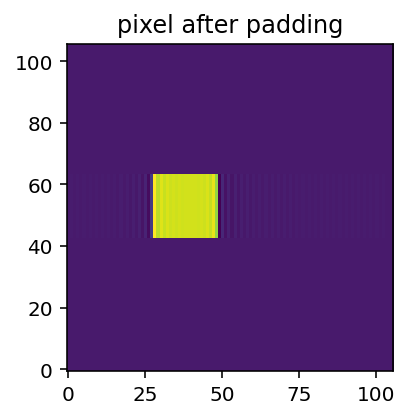

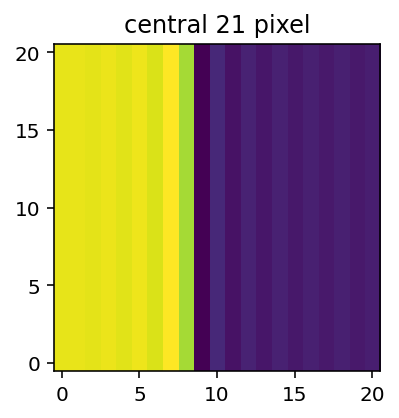

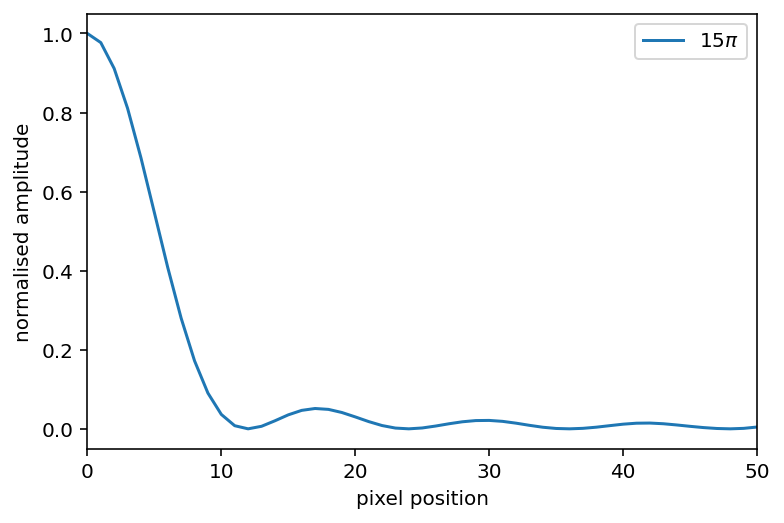

******************** 20 pi ********************


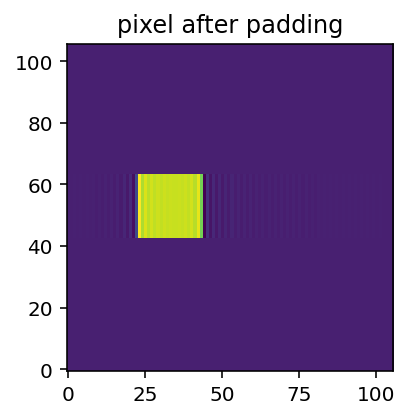

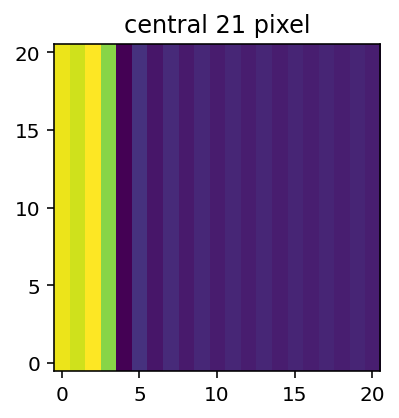

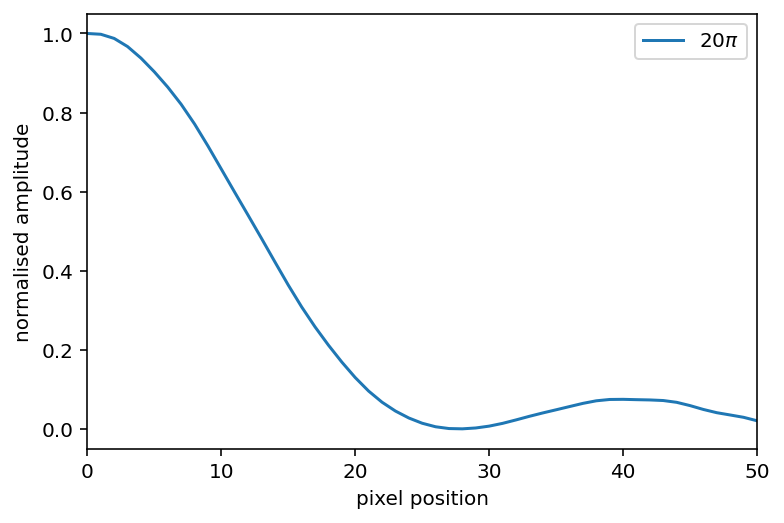

In [18]:
# creating Edet with square aperture, with 21 pixels
npix = 21
y,x = np.mgrid[:npix, :npix]
ampli = np.ones_like(y)
phase = np.zeros_like(y)  # zero phase across entire aperture

# make the complex amplitude E
E = ampli * np.exp(1j*phase)

# carry out the FT of E and add a spatial sampling of 5 by default
Edet = FFT(E,5)
# creating a ramp
phase = np.angle(Edet)
ramp = np.ones_like(phase)
plt.figure(figsize=(6,4))
Mult = [3,15,20]
for mult in Mult:
    fact = np.linspace(-mult*np.pi,mult*np.pi,phase.shape[0])
    new_ph = ramp*fact + phase
    amp = np.abs(Edet)
    E_re = amp*np.cos(new_ph)
    E_im = amp*np.sin(new_ph)
    Edet_new = E_re + 1j*E_im
    E_new = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(Edet_new)))
    #"""  
    print("*"*20,"{} pi".format(mult),"*"*20)
    fig, ax = plt.subplots(1, figsize=(3,3))
    ax.imshow(E_new.real)
    ax.set_title("pixel after padding")
    plt.show()
    #"""
    # locate in the central 21 pixels
    E_new = E_new[43:64,40:61]
    fig, ax = plt.subplots(1, figsize=(3,3))
    ax.imshow(E_new.real)
    ax.set_title("central 21 pixel")
    plt.show()
    #print(E_new.shape)
    
    
    
    Edet_n = FFT(E_new,5)
    #displC(Edet_n,100)
    Edet_ampl_n = np.abs(Edet_n)
    # determine intensity
    Idet = Edet_ampl_n * Edet_ampl_n
    # normalise to the brightest pixel
    Idet = Idet / np.max(Idet)

    # get central row in Edet and Idet
    nx, ny = Edet_ampl_n.shape

    yy, xx = np.mgrid[:nx,:ny]

    xc = int((nx + 1)/2.)
    yc = int((ny + 1)/2.)

    # central pixel is at yy,xx = (0,0)
    yy = yy - yc
    xx = xx - xc
    #print(xx.shape,Idet.shape,xc)
    plt.plot(xx[xc],Idet[xc],label='{}$\pi$'.format(mult))
    plt.xlim([0,50])
    plt.xlabel('pixel position')                 
    plt.ylabel('normalised amplitude')  
    plt.legend()
    plt.show()

It can be seen, with increasing multiples of $\pi$, the PSF moves leaftwards in real space and only a fraction of the sky can be seen by the telescope. This results in an ever shallower shape of PSF intensity, and its absolute intensity also  decreased.

---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:

number of hours taken here: ~ 4 hours.
